# Investigate HPS profile

In [1]:
%matplotlib inline

In [2]:
import asdfc
import pandas as pd
import scipy as sp
import numpy as np
import patsy as pat
import nibabel as nib
import pathlib as pal
import seaborn as sbn
import matplotlib as mpl
from matplotlib import gridspec
import nilearn.input_data as nii
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
root_p = pal.Path('/home/neuromod/ASD_project_clean')
model1_p = root_p / 'Results/Validation/validation_net_split_1_model_1_combined_p_values.tsv'
pheno_valid_p = root_p / 'Data/ABIDE_2_Pheno_PSM_matched_ados.tsv'
resid_valid_p = root_p / 'Results/Validation/abide_2_validation_residuals_regressed_with_abide_1.npy'
seed_valid_p = root_p / 'Data/abide_2_seed_maps_no_cereb.npy'

mask_p = root_p / 'ATLAS/MIST/Parcellations/MIST_mask_nocereb.nii.gz'
atlas_p = root_p / 'ATLAS/MIST/Parcellations/MIST_20_nocereb.nii.gz'
labels_p = root_p / 'ATLAS/MIST/Parcel_Information/MIST_20_nocereb.csv'

fig_p = root_p / 'Figures/fig2'
fig_p.mkdir(parents=True, exist_ok=True) 

In [4]:
def mm2in(mm):
    return mm/25.4

## Load and preparation

In [5]:
pheno_valid = pd.read_csv(pheno_valid_p, sep='\t')
model1 = pd.read_csv(model1_p, sep='\t')
model1.rename(columns={'V1': 'p_ASD', 'V2': 'p_TDC'}, inplace=True)
resid_valid = np.load(resid_valid_p)
seed_valid = np.load(seed_valid_p)

labels = pd.read_csv(labels_p, sep=';')
mask_i = nib.load(str(mask_p))
atlas_i = nib.load(str(atlas_p))
voxel_masker = nii.NiftiMasker(mask_img=mask_i, standardize=False)
voxel_masker.fit()

NiftiMasker(mask_img=<nibabel.nifti1.Nifti1Image object at 0x774879ea65c0>,
            memory=Memory(location=None))

In [6]:
# These need to be the values because the model 1 dataframe starts with index 1
pheno_valid.loc[:, 'is_hps'] = ((model1.p_ASD>0.2) & (model1.p_TDC<=0.2)).values
pheno_valid.loc[:, 'p_ASD'] = model1.loc[:, 'p_ASD'].values
pheno_valid.loc[:, 'p_TDC'] = model1.loc[:, 'p_TDC'].values

In [7]:
# Compute actual indices to avoid trusting the DF indices
hps_idx = np.where(pheno_valid.is_hps)[0]
non_hps_idx = np.where(~pheno_valid.is_hps)
non_hps_asd_idx = np.where((pheno_valid.is_hps) & (pheno_valid.DX_GROUP=='Autism'))[0]
non_hps_con_idx = np.where((pheno_valid.is_hps) & (pheno_valid.DX_GROUP=='Control'))[0]

## Describe symptom profile
- with ADOS raw totals
- with ADOS raw domain totals
- with SRS raw totals T (standardized)

In [8]:
p_hps_asd = pheno_valid.query('is_hps and DX_GROUP=="Autism"')
p_hps_con = pheno_valid.query('is_hps and DX_GROUP=="Control"')
p_idi_asd = pheno_valid.query('not is_hps and DX_GROUP=="Autism"')
p_idi_con = pheno_valid.query('not is_hps and DX_GROUP=="Control"')

In [9]:
def get_counts(pheno, var, ados_values=range(1,11)):
    values = pheno[var].value_counts().keys().tolist()
    counts = pheno[var].value_counts().tolist()
    # Compute counts for each value in case there aren't
    return [counts[values.index(val)] if val in values else 0 for val in ados_values]

In [10]:
def get_relative_counts(counts):
    return [count/sum(counts) for count in counts]

## Boxplot + Swarmplot raw ADOS TOTAL

In [11]:
asd_idi_color = 'lightcoral'
asd_hps_color = 'firebrick'
con_idi_color = 'lightgreen'
con_hps_color = 'darkgreen'

In [12]:
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Arial']

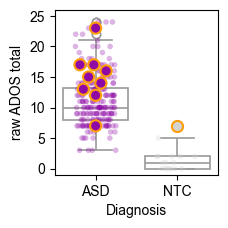

In [13]:
dpi = 300
scale_factor = 1
height = 55 * scale_factor
width = 55 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
ax = f.add_subplot(111)

sbn.boxplot(x='DX_GROUP', y='ADOS_RAW_TOTAL_combined', data=pheno_valid.query('not is_hps'), ax=ax, 
            hue='DX_GROUP', palette=['white', 'white'], saturation=1, linewidth=1.2, legend=False)
sbn.stripplot(x='DX_GROUP', y='ADOS_RAW_TOTAL_combined', data=pheno_valid.query('not is_hps'), size=4, ax=ax,
              hue='DX_GROUP', palette=['#8F09A7', 'lightgrey'], linewidth=0, alpha=0.3, jitter=0.25, legend=False)
sbn.swarmplot(x='DX_GROUP', y='ADOS_RAW_TOTAL_combined', data=pheno_valid.query('is_hps'), size=8, ax=ax,
              hue='DX_GROUP', palette=['#8F09A7', 'lightgrey'], linewidth=1.5, edgecolor='#FE9D08', legend=False)

ax.set_xticks([0, 1])
ax.set_xticklabels(['ASD', 'NTC'], fontsize=10)
ax.set_xlabel('Diagnosis', fontsize=10)

ax.set_yticks(np.arange(0,26,5))
ax.set_ylim([-1, 26])
ax.set_ylabel('raw ADOS total', fontsize=10)

f.savefig(fig_p / 'fig2_boxplot_rawADOS_new.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'fig2_boxplot_rawADOS_new.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

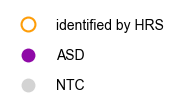

In [14]:
# Make a stupid legend by hand
dpi = 300
scale_factor = 1
height = 30 * scale_factor
width = 30 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=False)
ax = f.add_subplot(111)

ax.scatter(0,-0.5, s=100, color='lightgrey', edgecolor='#FE9D08', linewidth=0)
ax.scatter(0,0.5, s=100, color='#8F09A7', edgecolor='#FE9D08', linewidth=0)
ax.scatter(0,1.5, s=100, color='white', edgecolor='#FE9D08', linewidth=1.5)
ax.set_ylim([-1,2])
ax.set_xlim([-1,4])
#ax.set_xlim([-0.2,2])
ax.set_axis_off()

ax.annotate(f'identified by HRS', xy=(0.5,0.82), xytext=(0, 0), ha='left', va='center', 
            xycoords='axes fraction', textcoords='offset points', fontsize=10)
ax.annotate(f'ASD', xy=(0.5,0.49), xytext=(0, 0), ha='left', va='center', 
            xycoords='axes fraction', textcoords='offset points', fontsize=10)
ax.annotate(f'NTC', xy=(0.5,0.16), xytext=(0, 0), ha='left', va='center', 
            xycoords='axes fraction', textcoords='offset points', fontsize=10)
    

f.savefig(fig_p / 'fig2_boxplot_legend_new.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'fig2_boxplot_legend_new.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

## Boxplot + Swarmplot proxy ADOS CSS

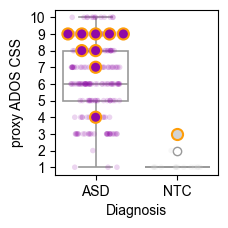

In [15]:
dpi = 300
scale_factor = 1
height = 55 * scale_factor
width = 55 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
ax = f.add_subplot(111)

sbn.boxplot(x='DX_GROUP', y='ADOS_CSS_proxy_fully', data=pheno_valid.query('not is_hps'), ax=ax, 
            hue='DX_GROUP', palette=['white', 'white'], saturation=1, linewidth=1.2, legend=False)
sbn.stripplot(x='DX_GROUP', y='ADOS_CSS_proxy_fully', data=pheno_valid.query('not is_hps'), size=4, ax=ax,
              hue='DX_GROUP', palette=['#8F09A7', 'lightgrey'], linewidth=0, alpha=0.17, jitter=0.3, legend=False)
sbn.swarmplot(x='DX_GROUP', y='ADOS_CSS_proxy_fully', data=pheno_valid.query('is_hps'), size=8, ax=ax,
              hue='DX_GROUP', palette=['#8F09A7', 'lightgrey'], linewidth=1.5, edgecolor='#FE9D08', legend=False)

ax.set_xticks([0, 1])
ax.set_xticklabels(['ASD', 'NTC'], fontsize=10)
ax.set_xlabel('Diagnosis', fontsize=10)
ax.set_yticks(np.arange(1,11))
ax.set_ylabel('proxy ADOS CSS', fontsize=10)

f.savefig(fig_p / 'fig2_boxplot_proxyADOS_new.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'fig2_boxplot_proxyADOS_new.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

# The brain profile
- go through each seed region
- average the HPS individuals
- show the map

In [16]:
# Networks that we are actually using:
# These are in R notation and thus start with 1
used_networks = np.array([18,  3,  9,  5, 16,  1, 13,  4, 12])-1
networks_not_used = np.array([2, 7, 10, 11,  6, 17,  8, 14, 15])-1
used_numbers = [labels.iloc[n].roi for n in used_networks]
not_used_numbers = [labels.iloc[n].roi for n in networks_not_used]

In [17]:
atlas = voxel_masker.transform(atlas_i)
new_atlas = np.zeros_like(atlas)
for n in used_numbers:
    new_atlas[atlas==n] = 1
new_atlas_i = voxel_masker.inverse_transform(new_atlas)

In [18]:
def mm2in(mm):
    return mm/25.4

In [19]:
def seed_map_overlay(width, height, img, over_img, coords, path):
    fig = plt.figure(figsize=(width, height), constrained_layout=True)
    ax = fig.add_subplot(111)
    gp = nlp.plot_stat_map(img, cut_coords=coords, axes=ax, colorbar=False)
    gp.add_contours(over_img, filled=False, alpha=1, levels=[0.5], colors='limegreen', linewidths=2)
    fig.savefig(path, bbox_inches='tight', dpi=300, transparent=True, pad_inches=0)

In [20]:
net_colors = ['#FFB647', # Light Orange
                   '#FF907E', '#FF6047', '#BF1A00', '#881200', # 2nd group, shades of red
                  '#BF7400', # Burnt Orange
                  '#FFEC7E', '#FFE347', '#BFA200', # 4th group, shades of yellow
                  '#6C98CA', '#3B72B0', '#09407D', # 5th group (prot), shades of blue
                  '#9EEB75', '#77E13E', '#3AA600', # 6th group (prot), shades of green
                  '#9D6ECD', '#783CB5', '#440981'] # 7th group (prot), shades of purple

In [21]:
import matplotlib.patches as patches

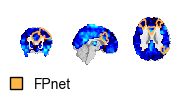

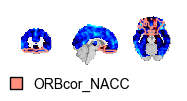

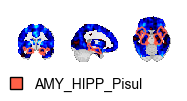

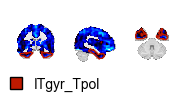

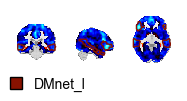

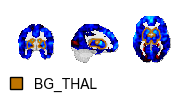

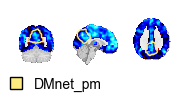

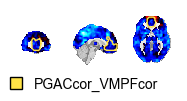

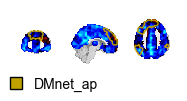

In [22]:
dpi=300
scale_factor = 1
height = 20 * scale_factor
width = 55 * scale_factor


coords = [(-2, 24, 24),
             (-2, 32, -18),
             (-22, -4, -16),
             (-41, -6, -34),
             (-48, -30, -4),
             (-18, -2, 4),
             (0, -57, 32),
             (0, 45, 0),
             (4, 42, 40)]

for fig_idx, nid in enumerate(used_networks):

    fig = plt.figure(figsize=(mm2in(width),mm2in(height)))
    gs = gridspec.GridSpec(nrows=1, ncols=1)
    ax_img = fig.add_subplot(gs[0])

    a = np.mean(resid_valid[hps_idx, :, nid], 0)
    img = voxel_masker.inverse_transform(a)
    # Make an image for just this seed region
    seed_vec = (voxel_masker.transform(atlas_i)==labels.iloc[nid].roi).squeeze()
    seed_img = voxel_masker.inverse_transform(seed_vec)
    
    gp = nlp.plot_stat_map(img, cut_coords=coords[fig_idx], axes=ax_img, colorbar=False, draw_cross=False, annotate=False, black_bg=False) #, threshold=1e-20 display_mode='ortho',cmap='Blues',vmax=0
    gp.add_contours(seed_img, filled=False, alpha=1, levels=[0.5], colors=net_colors[fig_idx], linewidths=1)
    
    net_name = labels.iloc[nid]["label"]    
    
    ax_img.set_axis_on()
    ax_img.patch.set_alpha(0)
    for spine in ax_img.spines.values():
        spine.set_visible(False)
    ax_img.set_xticks([])
    ax_img.set_yticks([])
    
    ax_img.annotate(f'{net_name}', xy=(0,0), xytext=(17, -5), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points', fontsize=10)
    ax_img.add_patch(plt.Rectangle((0,-0.32),0.07, 0.2,facecolor=net_colors[fig_idx],
                                   edgecolor='black', linewidth = 1, clip_on=False))
    
    fig.savefig(fig_p / f'hcs_avg_{net_name}_outline.png', bbox_inches='tight', dpi=dpi, transparent=False, pad_inches=0)
    fig.savefig(fig_p / f'hcs_avg_{net_name}_outline.pdf', bbox_inches='tight', dpi=dpi, transparent=False, pad_inches=0)

## Plot the brain atlas with corresponding colors

In [23]:
order = np.array([18,  3,  9,  5, 16,  1, 13,  4, 12,  2,  7, 10, 11,  6, 17,  8, 14,
       15])-1

In [24]:
# Manual partition
part_dict = {1: [18],
             2: [3, 9, 5, 16],
             3: [1],
             4: [13, 4, 12],
             5: [2, 7, 10],
             6: [11, 6, 17],
             7: [8, 14, 15]
            }
manual_part = np.array([p for i in order  for p, v in part_dict.items() if i+1 in v])

In [25]:
atlas = atlas_i.get_fdata().astype(int)
atlas_masked = np.zeros(shape=(atlas.shape))
atlas_ens1 = np.zeros(shape=(atlas.shape))
atlas_ens2 = np.zeros(shape=(atlas.shape))
idx = 1
for i in np.arange(1,8):    
    for j in part_dict[i]:
        # convert j to real j
        real_j = labels.iloc[j-1].roi
        if i <=4:
            atlas_ens1[atlas==real_j] = idx
            atlas_masked[atlas==real_j] = 1
            idx +=1
        else:
            atlas_ens2[atlas==real_j] = i
atlas_masked_i = nib.Nifti1Image(atlas_masked, affine=atlas_i.affine, header=atlas_i.header)
atlas_ens1_i = nib.Nifti1Image(atlas_ens1, affine=atlas_i.affine, header=atlas_i.header)

In [26]:
cmp = LinearSegmentedColormap.from_list('lala', net_colors, N=18)

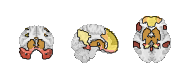

In [27]:
cut_coords = (10,5,0)
dpi=300
scale_factor = 1
height = 20 * scale_factor
width = 55 * scale_factor

fig = plt.figure(figsize=(mm2in(width),mm2in(height)))
ax = fig.add_subplot(111)
gp = nlp.plot_roi(atlas_ens1_i, cmap=cmp, cut_coords=cut_coords, axes=ax, vmin=1, vmax=18, draw_cross=False, annotate=False);
gp.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5], colors='black', linewidths=0.5)

fig.savefig(fig_p / 'fig2_ensemble1_maps_for_montage.png', bbox_inches='tight', dpi=dpi, transparent=False, pad_inches=0)
fig.savefig(fig_p / 'fig2_ensemble1_maps_for_montage.pdf', bbox_inches='tight', dpi=dpi, transparent=False, pad_inches=0)

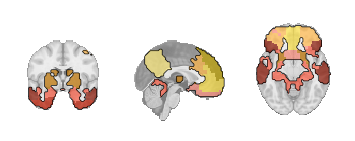

In [28]:
cut_coords = (0,0,-10)
dpi=300
scale_factor = 1
height = 40 * scale_factor
width = 110 * scale_factor

fig = plt.figure(figsize=(mm2in(width),mm2in(height)))
ax = fig.add_subplot(111)
gp = nlp.plot_roi(atlas_ens1_i, cmap=cmp, cut_coords=cut_coords, axes=ax, vmin=1, vmax=18, draw_cross=False, annotate=False);
gp.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5], colors='black', linewidths=0.5)